In [64]:
import numpy as np
import pandas as pd
import math

In [65]:
%ls

Exploring Ensemble Methods.ipynb
lending-club-data.csv
module-8-assignment-1-train-idx.json
module-8-assignment-1-validation-idx.json
module-8-boosting-assignment-1-blank.ipynb


In [66]:
loans = pd.read_csv('lending-club-data.csv')
loans.head()

/Users/tdx/anaconda2/envs/ds-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [67]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: +1 if x==0 else -1)
loans.drop(['bad_loans'], axis=1, inplace=True, errors='ignore')

In [68]:
'bad_loans' in loans.columns

False

###    Selecting features

In [69]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

### Skipping obervations with missing values

In [70]:
loans = loans[[target] + features].dropna()

In [71]:
train_idx = pd.read_json('module-8-assignment-1-train-idx.json')[0]
validation_idx = pd.read_json('module-8-assignment-1-validation-idx.json')[0]

### One-hot encoding

In [72]:
def one_hot_encoding(dataset, column, remove_categorical_column=False, inplace=False):
    result_dataset = dataset if inplace else dataset.copy()
    
    if column not in dataset.columns:
        return result_dataset
    
    all_categories = ([u for u in set(dataset[column].values)])
    all_categories.sort()
    
    for category in all_categories:
        new_name = "%s.%s" % (column, category)
        result_dataset[new_name] = (result_dataset[column] == category).apply(lambda u: 1 if u else 0)
    
    if remove_categorical_column:
        result_dataset = result_dataset.drop([column], axis=1, errors='ignore')
    
    return result_dataset

In [73]:
def one_hot_encoding_multiple_cols(dataset, columns, remove_categorical_column=False, inplace=False):
    result_dataset = dataset if inplace else dataset.copy()
    
    for column in columns:
        result_dataset = one_hot_encoding(result_dataset, column, remove_categorical_column=False, inplace=True)
    
    if remove_categorical_column:
        print (remove_categorical_column, len(result_dataset.columns))
        result_dataset.drop(columns, axis=1, inplace=True, errors='ignore')
        print (len(result_dataset.columns))
    
    # Since result_dataset lost reference to dataset, we need to assign new reference.
    if inplace: 
        dataset = result_dataset
        
    return result_dataset

In [74]:
categorical_variables = []

In [75]:
loans.dtypes

safe_loans                 int64
grade                     object
sub_grade_num            float64
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
payment_inc_ratio        float64
delinq_2yrs              float64
delinq_2yrs_zero         float64
inq_last_6mths           float64
last_delinq_none           int64
last_major_derog_none      int64
open_acc                 float64
pub_rec                  float64
pub_rec_zero             float64
revol_util               float64
total_rec_late_fee       float64
int_rate                 float64
total_rec_int            float64
annual_inc               float64
funded_amnt                int64
funded_amnt_inv            int64
installment              float64
dtype: object

In [76]:
loans.head()

,safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio,delinq_2yrs,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
0,1,B,0.4,0,11,RENT,27.65,credit_card,8.14350,0.0,...,0.0,1.0,83.7,0.00,10.65,861.07,24000.0,5000,4975,162.87
1,-1,C,0.8,1,1,RENT,1.00,car,2.39320,0.0,...,0.0,1.0,9.4,0.00,15.27,435.17,30000.0,2500,2500,59.83
2,1,C,1.0,0,11,RENT,8.72,small_business,8.25955,0.0,...,0.0,1.0,98.5,0.00,15.96,603.65,12252.0,2400,2400,84.33
3,1,C,0.2,0,11,RENT,20.00,other,8.27585,0.0,...,0.0,1.0,21.0,16.97,13.49,2209.33,49200.0,10000,10000,339.31
4,1,A,0.8,0,4,RENT,11.20,wedding,5.21533,0.0,...,0.0,1.0,28.3,0.00,7.90,631.38,36000.0,5000,5000,156.46


In [77]:
for feat_name, feat_type in zip(loans.columns, loans.dtypes):
    if (feat_type == 'object'):
        categorical_variables += [feat_name]

print (categorical_variables)

['grade', 'home_ownership', 'purpose']


In [78]:
loans.columns

Index(['safe_loans', 'grade', 'sub_grade_num', 'short_emp', 'emp_length_num',
       'home_ownership', 'dti', 'purpose', 'payment_inc_ratio', 'delinq_2yrs',
       'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none',
       'last_major_derog_none', 'open_acc', 'pub_rec', 'pub_rec_zero',
       'revol_util', 'total_rec_late_fee', 'int_rate', 'total_rec_int',
       'annual_inc', 'funded_amnt', 'funded_amnt_inv', 'installment'],
      dtype='object')

In [79]:
one_hot_encoding_multiple_cols(loans, categorical_variables, remove_categorical_column=True, inplace=True)

True 48
45


,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.debt_consolidation,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding
0,1,0.4,0,11,27.65,8.143500,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1,0.8,1,1,1.00,2.393200,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1.0,0,11,8.72,8.259550,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,0.2,0,11,20.00,8.275850,0.0,1.0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0.8,0,4,11.20,5.215330,0.0,1.0,3.0,1,...,0,0,0,0,0,0,0,0,0,1
5,1,0.2,0,10,5.35,2.735750,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,0,0,0
6,-1,0.4,0,5,5.55,4.571700,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0
7,-1,1.0,1,1,18.08,9.716000,0.0,1.0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
8,1,0.6,0,6,16.12,2.557500,0.0,1.0,2.0,1,...,1,0,0,0,0,0,0,0,0,0
9,1,1.0,0,11,10.78,6.440640,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [81]:
loans.columns

Index(['safe_loans', 'sub_grade_num', 'short_emp', 'emp_length_num', 'dti',
       'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero',
       'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none',
       'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util',
       'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc',
       'funded_amnt', 'funded_amnt_inv', 'installment', 'grade.A', 'grade.B',
       'grade.C', 'grade.D', 'grade.E', 'grade.F', 'grade.G',
       'home_ownership.MORTGAGE', 'home_ownership.OTHER', 'home_ownership.OWN',
       'home_ownership.RENT', 'purpose.car', 'purpose.credit_card',
       'purpose.debt_consolidation', 'purpose.home_improvement',
       'purpose.house', 'purpose.major_purchase', 'purpose.medical',
       'purpose.moving', 'purpose.other', 'purpose.small_business',
       'purpose.vacation', 'purpose.wedding'],
      dtype='object')

In [82]:
train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

In [84]:
validation_data.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.debt_consolidation,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0
60,-1,0.4,0,5,12.48,3.57024,0.0,1.0,3.0,1,...,0,0,0,0,0,0,0,1,0,0
93,-1,0.4,0,11,23.18,14.70090,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0
132,-1,0.2,0,3,7.83,11.04860,0.0,1.0,2.0,1,...,1,0,0,0,0,0,0,0,0,0


## Gradient boosted tree classifier

In [86]:
from sklearn.ensemble import GradientBoostingClassifier

In [114]:
model_5 = GradientBoostingClassifier(max_depth=6, n_estimators=5)

In [115]:
train_features = train_data.drop(['safe_loans'], axis=1).to_numpy()
train_target = train_data['safe_loans'].to_numpy()

In [116]:
train_target

array([-1, -1, -1, ...,  1,  1,  1])

In [117]:
model_5.fit(train_features, train_target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=5,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [118]:
prediction = model_5.decision_function(train_features)

In [119]:
class_prediction = [1 if u > 0 else -1 for u in prediction]

In [120]:
right_prediction = (class_prediction == train_target).sum()
right_prediction

24769

In [121]:
len(train_target)

37219

In [122]:
accuracy = right_prediction / len(train_target)
accuracy

0.6654934307746043

### Making predictions

In [123]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.debt_consolidation,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


### Quiz question: What percentage of the predictions on sample_validation_data did model_5 get correct?



In [124]:
def to_features_and_output_matrix(dataframe, target_column):
    features_matrix = dataframe.drop([target_column], axis=1).to_numpy()
    output_matrix = dataframe[target_column].to_numpy()
    return (features_matrix, output_matrix)


In [125]:
sample_features_matrix, sample_output_matrix = to_features_and_output_matrix(
    sample_validation_data, 'safe_loans'
)

In [127]:
sample_predictions = model_5.predict(sample_features_matrix)

In [129]:
sample_output_matrix

array([ 1,  1, -1, -1])

In [128]:
sample_predictions

array([ 1,  1, -1,  1])

In [131]:
# Result
(sample_output_matrix == sample_predictions).sum() / len(sample_predictions)

0.75

### Prediction Probabilities

In [134]:
sample_predicted_proba = model_5.predict_proba(sample_features_matrix)

### Quiz Question: Which loan has the highest probability of being classified as a safe loan?



In [142]:
sample_predicted_proba

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

In [140]:
sample_predicted_proba[:,1]

array([0.58357669, 0.53050311, 0.46192208, 0.60408361])

In [143]:
id = sample_predicted_proba[:,1].argmax()
print ("(%d)th loans was classified as the safest loan. Proba = %f" % ((1+id), sample_predicted_proba[:,1][id]))

(4)th loans was classified as the safest loan. Proba = 0.604084


### Evaluating the model on the validation data

In [195]:
validation_features_matrix, validation_output = to_features_and_output_matrix(
    validation_data,
    'safe_loans'
)

In [196]:
model_5.score(validation_features_matrix, validation_output)

0.6613528651443343

### 14. Calculate the number of false positives made by the model on the validation_data.



### Quiz question: What is the number of false positives on the validation_data?



In [151]:
prediction_validation = model_5.predict(validation_features_matrix)

In [150]:
false_positives = ((prediction_validation == 1) & (validation_output == -1)).sum()
false_positives

1653

### 15. Calculate the number of false negatives made by the model on the validation_data.



In [152]:
false_negatives = ((prediction_validation == -1) & (validation_output == 1)).sum()
false_negatives

1491

## Comparison with decision trees

### 16. Calculate the cost of mistakes made by model_5 on the validation_data.



### Quiz Question: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?



In [153]:
cost = false_positives * 20000 + false_negatives * 10000
cost

47970000

### Most positive and negative loans

In [154]:
prediction_proba_validation = model_5.predict_proba(validation_features_matrix)

In [155]:
prediction_proba_validation

array([[0.53807792, 0.46192208],
       [0.39591639, 0.60408361],
       [0.52012758, 0.47987242],
       ...,
       [0.53530977, 0.46469023],
       [0.52280924, 0.47719076],
       [0.53807792, 0.46192208]])

### Find the top 5 loans with the highest probability of being predicted as a safe loan.

Quiz question: What grades are the top 5 loans?

In [157]:
len(prediction_proba_validation[:,1]), len(validation_features_matrix)

(9284, 9284)

In [159]:
validation_data_clone = validation_data.copy()

In [160]:
validation_data_clone['predictions'] = prediction_proba_validation[:,1]

### Top 5 loans

In [192]:
top_5_loans = validation_data_clone.sort_values(by=['predictions'],ascending=False)[0:5]
top_5_loans

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding,predictions
8021,-1,0.4,0,4,12.73,12.16700,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.673059
56222,1,0.2,0,11,3.51,5.06448,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.661468
4545,1,0.2,0,11,5.01,2.21353,0.0,1.0,0.0,0,...,0,0,1,0,0,0,0,0,0,0.661468
44769,1,0.4,0,2,14.63,5.60827,0.0,1.0,3.0,1,...,0,0,0,0,0,0,0,0,0,0.661468
73426,1,0.2,0,6,10.29,3.22264,0.0,1.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0.661468


In [194]:
top_5_loans[['grade.A', 'grade.B', 'grade.C', 'grade.D', 'grade.E', 'grade.F']]

,grade.A,grade.B,grade.C,grade.D,grade.E,grade.F
8021,1,0,0,0,0,0
56222,1,0,0,0,0,0
4545,1,0,0,0,0,0
44769,1,0,0,0,0,0
73426,1,0,0,0,0,0


### Bottom 5 loans

In [164]:
validation_data_clone.sort_values(by=['predictions'],ascending=True)[0:5]

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.home_improvement,purpose.house,purpose.major_purchase,purpose.medical,purpose.moving,purpose.other,purpose.small_business,purpose.vacation,purpose.wedding,predictions
58794,-1,0.8,0,2,8.66,17.62510,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.307334
84508,-1,0.8,1,1,7.37,16.62070,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.307334
27502,-1,1.0,0,3,8.53,14.62800,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0.312806
114781,-1,0.4,0,3,21.90,7.18760,1.0,0.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0.315969
84921,-1,0.8,0,9,8.54,7.48113,0.0,1.0,2.0,0,...,0,0,0,0,0,1,0,0,0,0.315969


### Effect of adding more trees

In [167]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6)

In [168]:
model_10.fit(train_features, train_target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [170]:
acc_10 = model_10.score(validation_features_matrix, validation_output)
acc_10

0.6654459284791039

### 50 trees

In [171]:
model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6)
model_50.fit(train_features, train_target)
acc_50 = model_50.score(validation_features_matrix, validation_output)
acc_50

0.6844032744506678

### 100 trees

In [172]:
model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6)
model_100.fit(train_features, train_target)
acc_100 = model_100.score(validation_features_matrix, validation_output)
acc_100

0.6883886255924171

### 200 trees

In [173]:
model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6)
model_200.fit(train_features, train_target)
acc_200 = model_200.score(validation_features_matrix, validation_output)
acc_200

0.6860189573459715

### 500 trees

In [174]:
model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6)
model_500.fit(train_features, train_target)
acc_500 = model_500.score(validation_features_matrix, validation_output)
acc_500

0.6891426109435588

In [205]:
model_500.validation_fraction

0.1

700 trees

In [191]:
model_700 = GradientBoostingClassifier(n_estimators=700, max_depth=6)
model_700.fit(train_features, train_target)
acc_700 = model_700.score(validation_features_matrix, validation_output)
acc_700

0.6859112451529513

### Quiz Question: Which model has the best accuracy on the validation_data?



In [175]:
np.array([acc_10, acc_50, acc_100, acc_200, acc_500]).argmax()

4

### Quiz Question: Is it always true that the model with the most trees will perform best on test data?



### Plot the training and validation error vs. number of trees


In [185]:
train_err_10 = 1 - model_10.score(train_features, train_target)
train_err_50 = 1 - model_50.score(train_features, train_target)
train_err_100 = 1 - model_100.score(train_features, train_target)
train_err_200 = 1 - model_200.score(train_features, train_target)
train_err_500 = 1 - model_500.score(train_features, train_target)
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]
training_errors

[0.32891802573954165,
 0.28270506999113354,
 0.25409065262365993,
 0.21271393643031788,
 0.13168005588543485]

In [190]:
validation_errors = 1.0 - np.array([acc_10, acc_50, acc_100, acc_200, acc_500])
validation_errors

array([0.33455407, 0.31559673, 0.31161137, 0.31398104, 0.31085739])

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

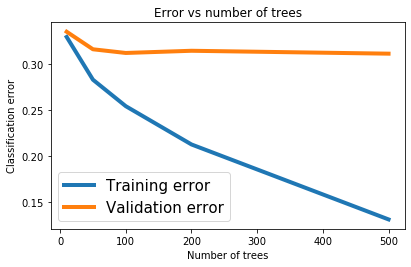

In [188]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

### Quiz question: Does the training error reduce as the number of trees increases?



## YES

### Quiz question: Is it always true that the validation error will reduce as the number of trees increases?



### NO